In [2]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import time

In [3]:
train_data_2016 = pd.read_csv('./zillow data/train_2016_v2.csv')
train_data_2017 = pd.read_csv('./zillow data/train_2017.csv')
properties_2017 = pd.read_csv('./zillow data/properties_2017.csv')
properties_2016 = pd.read_csv('./zillow data/properties_2016.csv')

/Users/apple/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/apple/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def label_encode_features(data, features, show_info = False):
    df = data.loc[:,features]
    print('encoding labels ....')
    for index1,ele in enumerate(features):
        p = data.loc[:,ele]
        p = p.sort_values(ascending = True)
        size_mapping = dict()
        for index2, element in enumerate(p.unique()):
            size_mapping[element] = index2
        p = p.map(size_mapping)
        if show_info == True:
            print(ele)
        p = p.replace(len(p.unique())-1,np.nan)
        df.loc[:,ele] = p
    print('merging results ..... ')
    for ele in features:
        if show_info == True:
            print(ele)
        data[ele] = df.loc[:,ele]
    print('successfully done.....')
    return data

In [5]:
string_feature= ['hashottuborspa','propertycountylandusecode','propertyzoningdesc','taxdelinquencyflag', 'fireplaceflag']

In [26]:
class_feature = ['airconditioningtypeid', 'architecturalstyletypeid','buildingclasstypeid','buildingqualitytypeid',
                'decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10', 'pooltypeid2', 'pooltypeid7',
                'propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock',
                'regionidcity','regionidcounty', 'regionidneighborhood', 'regionidzip','storytypeid','typeconstructiontypeid',
                'fireplaceflag','taxdelinquencyflag','taxdelinquencyyear','censustractandblock']

In [6]:
properties_2016 = label_encode_features(properties_2016,string_feature,show_info = False)
properties_2017 = label_encode_features(properties_2017,string_feature,show_info = False)

encoding labels ....
merging results ..... 
successfully done.....
encoding labels ....
merging results ..... 
successfully done.....


In [27]:
properties_2016 = label_encode_features(properties_2016,class_feature,show_info = False)
properties_2017 = label_encode_features(properties_2017,class_feature,show_info = False)

encoding labels ....
merging results ..... 
successfully done.....
encoding labels ....
merging results ..... 
successfully done.....


In [28]:
merged_2016 = pd.merge(train_data_2016,properties_2016,on="parcelid",how="left")
merged_2016

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,0.0,NaN,NaN,2.0,3.0,NaN,3.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,1341.0
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0.0,NaN,NaN,3.0,2.0,NaN,3.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,34808.0
3,12643413,0.0218,2016-01-02,0.0,NaN,NaN,2.0,2.0,NaN,3.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,21016.0
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,74466.0
5,11509835,-0.2705,2016-01-02,0.0,NaN,NaN,4.0,4.0,NaN,0.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,56234.0
6,12286022,0.0440,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,6.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,43936.0
7,17177301,0.1638,2016-01-02,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,NaN,91756.0
8,14739064,-0.0030,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,NaN,74026.0
9,14677559,0.0843,2016-01-03,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.26,NaN,NaN,76905.0


In [29]:
merged_2017 = pd.merge(train_data_2017,properties_2017,on="parcelid",how="left")

In [30]:
merged_2017.to_csv('./zillow data/merged_2017 v4.csv')
merged_2016.to_csv('./zillow data/merged_2016 v4.csv')
properties_2016.to_csv('./zillow data/properties_2016 v4.csv')
properties_2017.to_csv('./zillow data/properties_2017 v4.csv')

In [31]:
train_datapath_2016 = "./zillow data/merged_2016 v4.csv"
train_datapath_2017 = "./zillow data/merged_2017 v4.csv"

test_datapath_2016 = "./zillow data/properties_2016 v4.csv"
test_datapath_2017 = "./zillow data/properties_2017 v4.csv"

In [32]:
# modify 'transactiondate' of df to keep only the month
def parse_transactiondate(df):
    # modify transactiondate col to keep only the month
    new_transactiondate = []
    for data in df['transactiondate']:
        temp = data.split("-")
        new_transactiondate.append(int(temp[1])) # keep only month

    new_transactiondate = np.array(new_transactiondate)
    new_transactiondate = new_transactiondate.reshape(new_transactiondate.shape[0], 1)

    df['transactiondate'] = new_transactiondate

# return label index, feature index list
# assumes that df label_is_first
def split_on_label(df):
    return df.columns[0], df.columns[1:]

def gen_testdata(df, new_transactiondate):
    df_copy = df.copy()
    # df_copy['transactiondate'] = new_transactiondate
    df_copy.insert(0, 'transactiondate', new_transactiondate)
    return df_copy

def get_low_var_feature(support_list):
    low_var_feature_index = []
    support_feature_index = []
    for i in range(len(support_list)):
        if support_list[i]:
            support_feature_index.append(i)
        else:
            low_var_feature_index.append(i)
    return low_var_feature_index, support_feature_index

def handle_low_var(sel, train_data, feature_list):
    temp_sel = sel.fit(train_data)
    low_var_list, support_list = get_low_var_feature(sel.get_support())
    
    for i in low_var_list:
        print(feature_list[i])
    return temp_sel, support_list

In [33]:
# read training data
train_data16 = pd.read_csv(train_datapath_2016, index_col=0)
train_data17 = pd.read_csv(train_datapath_2017, index_col=0)

# drop parcelid (index of properties features)
train_data16 = train_data16.drop('parcelid', axis=1)
train_data17 = train_data17.drop('parcelid', axis=1)

label16, feature16 = split_on_label(train_data16)
label17, feature17 = split_on_label(train_data17)

print("[2016] num of features:", len(feature16))
print("[2016] num of instances:", train_data16.shape[0])

print("[2017] num of features:", len(feature17))
print("[2017] num of instances:", train_data17.shape[0])

# modify 'transactiondate' to keep only the month
parse_transactiondate(train_data16)
parse_transactiondate(train_data17)

# training data and label for model 2016
X_train16 = train_data16[feature16]
y_train16 = train_data16[label16]

# training data and label for model 2017
X_train17 = train_data17[feature17]
y_train17 = train_data17[label17]

[2016] num of features: 58
[2016] num of instances: 90275
[2017] num of features: 58
[2017] num of instances: 77613


In [5]:
# Removing Features with low variance
# it should remove features with many missing values that were filled by imputation

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

print("Low Var Features 2016:")
sel16, support_list16 = handle_low_var(sel, X_train16, feature16)

print("\nLow Var Features 2017:")
sel17, support_list17 = handle_low_var(sel, X_train17, feature17)
    
new_X_train16 = sel16.transform(X_train16)
new_X_train17 = sel17.transform(X_train17)

assert(len(support_list16) == new_X_train16.shape[1]), "Error: Invalid Size"
assert(len(support_list17) == new_X_train17.shape[1]), "Error: Invalid Size"

new_feature16 = feature16[support_list16]
new_feature17 = feature17[support_list17]

print("\n[2016] num of features:", new_X_train16.shape[1])
print("[2017] num of features:", new_X_train17.shape[1])

Low Var Features 2016:
architecturalstyletypeid
buildingclasstypeid
decktypeid
fireplacecnt
hashottuborspa
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
threequarterbathnbr
typeconstructiontypeid
numberofstories
fireplaceflag
assessmentyear
taxdelinquencyflag

Low Var Features 2017:
architecturalstyletypeid
buildingclasstypeid
decktypeid
fireplacecnt
hashottuborspa
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
threequarterbathnbr
typeconstructiontypeid
numberofstories
fireplaceflag
assessmentyear
taxdelinquencyflag

[2016] num of features: 42
[2017] num of features: 42


### Feauture Selection

In [49]:
def handle_lightGBM_RFECV(X_train, y_train):
    
    params = {"learning_rate":0.006,
              #'n_estimators':100,
              #'num_leaves':100,
              #'reg_alpha':0.01,
              #'reg_lambda':0.01,
              #'min_split_gain':0.1,
              #'min_child_samples':100,
              #'subsample':1.0,
              #'subsample_for_bin':50000
             }
    bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            #n_estimators = params['n_estimators'],
                            #num_leaves = params['num_leaves'],
                            #reg_alpha = params['reg_alpha'],
                            #reg_lambda = params['reg_lambda'],
                            #min_split_gain = params['min_split_gain'],
                            #min_child_samples = params['min_child_samples'],
                            #subsample = params['subsample'],
                            #subsample_for_bin = params['subsample_for_bin'],
                           )
    # cross-validate on num of features selected using RFECV
    # step parameter is number of features to remove at each step
    selector = RFECV(bst, step=1, cv=5)
    # selector = RFE(bst, 7, step=5)
    selector = selector.fit(X_train, y_train)
        
    # selected feature index
    feature = []
    for j in range(len(selector.support_)):
        if selector.support_[j]:
            feature.append(j)

    print("size of opt_feature from CV:", selector.n_features_)

    # obtain train MAE with CV'ed alpha value
    bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            #n_estimators = params['n_estimators'],
                            #num_leaves = params['num_leaves'],
                            #reg_alpha = params['reg_alpha'],
                            #reg_lambda = params['reg_lambda'],
                            #min_split_gain = params['min_split_gain'],
                            #min_child_samples = params['min_child_samples'],
                            #subsample = params['subsample'],
                            #subsample_for_bin = params['subsample_for_bin']
                           )
    #bst.fit(X_train[:,feature], y_train)
    #y_pred = bst.predict(X_train[:,feature])
    #print("Train MAE: {:.6}".format(mean_absolute_error(y_train, y_pred)))
    
    return bst,feature,selector

In [50]:
start_time = time.time()

print("RFECV Model 2016:")
bst16, opt_feature, selector = handle_lightGBM_RFECV(X_train16, y_train16)

elapsed_time = time.time() - start_time
print(time.strftime("Elasped time: %H:%M:%S", time.gmtime(elapsed_time)))

RFECV Model 2016:
size of opt_feature from CV: 11
Elasped time: 00:10:27


In [51]:
bst.fit(X_train16.iloc[:,opt_feature], y_train16)
y_pred = bst.predict(X_train16.iloc[:,opt_feature])
print("Train MAE: {:.6}".format(mean_absolute_error(y_train16, y_pred)))

Train MAE: 0.067816


In [53]:
X_train16_rfe = X_train16.iloc[:,opt_feature]

In [45]:
selector.support_

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False,  True,  True, False,  True,
        True, False,  True,  True])

### Tunig Parameters

In [62]:
dtrain16 = lgb.Dataset(X_train16, label=y_train16,categorical_feature = class_feature,free_raw_data=False) 
dtrain17 = lgb.Dataset(X_train17, label=y_train17,free_raw_data=False) 
dtrain16 = dtrain16.construct()
dtrain17 = dtrain17.construct()

In [63]:
dtrain17.num_feature()
dtrain17.num_data()

77613

In [206]:
params = {
        'boosting_type': 'dart',  # np.random.choice(['dart', 'gbdt']),
        'objective': 'regression l1',
        'metric': 'l1', 
    
        'learning_rate':0.014,
        'cat_smooth':30,
        'min_data_per_group':15000,
    
        'num_leaves': 63,
        'max_depth': 10,
        'min_data_in_leaf': 60,
    
        'feature_fraction': 1.0,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
    
        'lambda_l1': 4.64,
        'lambda_l2': 10,
        'min_gain_to_split': 0.0,
        'min_sum_hessian_in_leaf': 0.001,
        
        'drop_rate':0.018,
        'max_drop':50,
        'drop_seed':4,
    
        #'verbose': 0,
        #'is_training_metric': 'True'
    }
print(params)

{'boosting_type': 'dart', 'objective': 'regression l1', 'metric': 'l1', 'learning_rate': 0.014, 'cat_smooth': 20, 'min_data_per_group': 7000, 'num_leaves': 63, 'max_depth': 10, 'min_data_in_leaf': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 4.64, 'lambda_l2': 10, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 0.001, 'drop_rate': 0.018, 'max_drop': 50, 'drop_seed': 4}


In [214]:
tuned_param = 'learning_rate'
param_value_list = [0.013,0.014,0.015]

for param_value in param_value_list:
    
    params[tuned_param] = param_value
    
    cv_result = lgb.cv(params, dtrain16, stratified=False, nfold = 5, num_boost_round=500, early_stopping_rounds=50, seed = 21)
    
    print('mean: %f, std: %f, params: {%s: %f}'% (min(cv_result['l1-mean']), min(cv_result['l1-stdv']), tuned_param, param_value))

/Users/apple/venv/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


mean: 0.067577, std: 0.000779, params: {learning_rate: 0.013000}
mean: 0.067575, std: 0.000782, params: {learning_rate: 0.014000}
mean: 0.067575, std: 0.000777, params: {learning_rate: 0.015000}


In [34]:
def handle_lightgbm_GridCV(X, y, param_dict):
    
    # cross-validate on alpha (regularization strenght) from alphalist
    
    gbm = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False)
       
    # cross-validate on random search CV
    grid_search = GridSearchCV(gbm,param_grid=param_dict,
                               cv=5, scoring='neg_mean_absolute_error')
    
    start = time.time()
    grid_search.fit(X, y)
    print("GridSearchCV took %.2f seconds"
          " parameter settings." % (time.time() - start))

    return grid_search

In [231]:
params_dict = {
    'boosting_type':['dart'],
    "learning_rate":[0.014],
    'num_leaves':[63],
    'max_depth':[10],
    'reg_alpha':[4.64],
    'reg_lambda':[10],
    'min_split_gain':[0],
    'min_child_samples':[60],
    'colsample_bytree':[1.0],
    
    # drop params
    'drop_rate':[0.018],
    'max_drop':[50],
    'drop_seed':[4],
    
    'min_child_weight':[0.001],
    'subsample':[0.8],
    'subsample_for_bin':[200000],
    'subsample_freq':[1], 
    'n_eatimators':[512]
}
grid_result = handle_lightgbm_GridCV(X_train16, y_train16, params_dict)

GridSearchCV took 48.37 seconds parameter settings.


In [233]:
grid_result.grid_scores_

/Users/apple/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.06765, std: 0.00302, params: {'boosting_type': 'dart', 'colsample_bytree': 1.0, 'drop_rate': 0.018, 'drop_seed': 4, 'learning_rate': 0.014, 'max_depth': 10, 'max_drop': 50, 'min_child_samples': 60, 'min_child_weight': 0.001, 'min_split_gain': 0, 'n_eatimators': 512, 'num_leaves': 63, 'reg_alpha': 4.64, 'reg_lambda': 10, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1}]

### Learning curve

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    
    train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, train_sizes=train_sizes, scoring = 'neg_mean_absolute_error',verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"number of samples")
        plt.ylabel(u"score")
        plt.gca().invert_yaxis()
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"training set score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"validation set score")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

/Users/apple/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/apple/venv/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


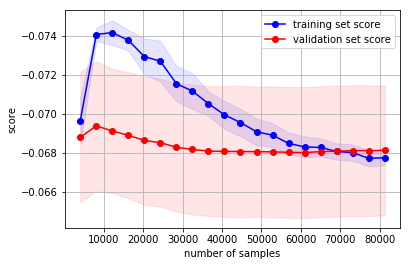

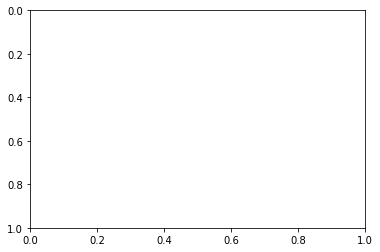

In [12]:
params = {"learning_rate":0.004,
          'n_estimators':100,
          'num_leaves':1000,
          'reg_alpha':0.01,
          'reg_lambda':0.01,
          'min_split_gain':0.1,
          'min_child_samples':100,
          'subsample':1.0,
          'subsample_for_bin':50000
         }
bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            n_estimators = params['n_estimators'],
                            num_leaves = params['num_leaves'],
                            reg_alpha = params['reg_alpha'],
                            reg_lambda = params['reg_lambda'],
                            min_split_gain = params['min_split_gain'],
                            min_child_samples = params['min_child_samples'],
                            subsample = params['subsample'],
                            subsample_for_bin = params['subsample_for_bin'],
                           )
_,_ = plot_learning_curve(bst, X_train16, y_train16, cv = 10)

### Train and Test on best model

In [127]:
X_test10_16 = X_test10_16.iloc[:,support_list16]
X_test11_16 = X_test11_16.iloc[:,support_list16]
X_test12_16 = X_test12_16.iloc[:,support_list16]

X_test10_17 = X_test10_17.iloc[:,support_list17]
X_test11_17 = X_test11_17.iloc[:,support_list17]
X_test12_17 = X_test12_17.iloc[:,support_list17]
print(X_test10_16.shape)

(2985217, 42)


In [216]:
# read in test
test_data2016 = pd.read_csv(test_datapath_2016, index_col=0)
test_data2017 = pd.read_csv(test_datapath_2017, index_col=0)

print("[2016] num of instances: ", test_data2016.shape[0])
print("[2017] num of instances: ", test_data2017.shape[0])

# save parcelid for merge 
test_parcelid16 = test_data2016['parcelid']
test_parcelid17 = test_data2017['parcelid']

# drop parcelid col
test_data2016 = test_data2016.drop('parcelid', axis=1)
test_data2017 = test_data2017.drop('parcelid', axis=1)

# generate transaction date
test10_16 = np.repeat(10, test_data2016.shape[0])
test11_16 = np.repeat(11, test_data2016.shape[0])
test12_16 = np.repeat(12, test_data2016.shape[0])

test10_17 = np.repeat(10, test_data2017.shape[0])
test11_17 = np.repeat(11, test_data2017.shape[0])
test12_17 = np.repeat(12, test_data2017.shape[0])

# get new test data with transaction date
X_test10_16 = gen_testdata(test_data2016, test10_16)
X_test11_16 = gen_testdata(test_data2016, test11_16)
X_test12_16 = gen_testdata(test_data2016, test12_16)

X_test10_17 = gen_testdata(test_data2017, test10_17)
X_test11_17 = gen_testdata(test_data2017, test11_17)
X_test12_17 = gen_testdata(test_data2017, test12_17)

/Users/apple/venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


[2016] num of instances:  2985217
[2017] num of instances:  2985217


In [227]:
def train_and_test_lgb(dtrain,X_test,params):
    
    gbm = lgb.train(params, dtrain, num_boost_round=500, verbose_eval=True)
    y_pred = gbm.predict(X_test10_16)
    
    return y_pred,gbm

In [229]:
best_params_16 = {'boosting_type': 'dart',  # np.random.choice(['dart', 'gbdt']),
                  'objective': 'regression l1',
                  'metric': 'l1', 
    
                  'learning_rate':0.014,
                  'cat_smooth':30,
                  'min_data_per_group':15000,
    
                  'num_leaves': 63,
                  'max_depth': 10,
                  'min_data_in_leaf': 60,
    
                  'feature_fraction': 1.0,
                  'bagging_fraction': 0.8,
                  'bagging_freq': 1,
    
                  'lambda_l1': 4.64,
                  'lambda_l2': 10,
                  'min_gain_to_split': 0.0,
                  'min_sum_hessian_in_leaf': 0.001,
        
                  'drop_rate':0.018,
                  'max_drop':50,
                  'drop_seed':4
                 }
y_pred10_16,gbm = train_and_test_lgb(dtrain16, X_test10_16.values,best_params_16)
y_pred11_16,_ = train_and_test_lgb(dtrain16, X_test11_16.values,best_params_16)
y_pred12_16,_ = train_and_test_lgb(dtrain16, X_test12_16.values,best_params_16)

best_params_17 = {
                  'boosting_type': 'dart',  # np.random.choice(['dart', 'gbdt']),
                  'objective': 'regression l1',
                  'metric': 'l1', 
    
                  'learning_rate':0.014,
                  'cat_smooth':30,
                  'min_data_per_group':15000,
    
                  'num_leaves': 63,
                  'max_depth': 10,
                  'min_data_in_leaf': 60,
    
                  'feature_fraction': 1.0,
                  'bagging_fraction': 0.8,
                  'bagging_freq': 1,
    
                  'lambda_l1': 4.64,
                  'lambda_l2': 10,
                  'min_gain_to_split': 0.0,
                  'min_sum_hessian_in_leaf': 0.001,
        
                  'drop_rate':0.018,
                  'max_drop':50,
                  'drop_seed':4
                  }
y_pred10_17,_ = train_and_test_lgb(dtrain17, X_test10_17.values,best_params_17)
y_pred11_17,_ = train_and_test_lgb(dtrain17, X_test11_17.values,best_params_17)
y_pred12_17,_ = train_and_test_lgb(dtrain17, X_test12_17.values,best_params_17)

/Users/apple/venv/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


TypeError: train_and_test() missing 1 required positional argument: 'params'

In [222]:
def train_and_test(X_train,y_train,X_test, params):
    
    bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            boosting_type = params['boosting_type'],
                            learning_rate = params['learning_rate'],
                            n_estimators = params['n_estimators'],
                            num_leaves = params['num_leaves'],
                            max_depth =params['max_depth'],
                            reg_alpha = params['reg_alpha'],
                            reg_lambda = params['reg_lambda'],
                            min_split_gain = params['min_split_gain'],
                            min_child_samples = params['min_child_samples'],
                            subsample = params['subsample'],
                            min_child_weight = params['min_child_weight'],
                            subsample_for_bin = params['subsample_for_bin'],
                            colsample_bytree = params['colsample_bytree'],
                            subsample_freq = params['subsample_freq'],
                            drop_rate = params['drop_rate'],
                            max_drop = params['max_drop'],
                            drop_seed = params['drop_seed']                                                     
                           )
    bst.fit(X_train, y_train)
    y_pred = bst.predict(X_test)
    
    return y_pred

In [223]:
best_params_16 = {'boosting_type':'dart',
                  "learning_rate":0.014,
                  'num_leaves':63,
                  'max_depth':10,
                  'reg_alpha':4.64,
                  'reg_lambda':10,
                  'min_split_gain':0,
                  'min_child_samples':60,
                  'colsample_bytree':1.0,
                  'drop_rate':0.018,
                  'max_drop':50,
                  'drop_seed':4,
    
                  'min_child_weight':0.001,
                  'subsample':0.8,
                  'subsample_for_bin':200000,
                  'subsample_freq':1, 
                  'n_estimators':512
                 }
y_pred10_16 = train_and_test(X_train16, y_train16, X_test10_16.values,best_params_16)
y_pred11_16 = train_and_test(X_train16, y_train16, X_test11_16.values,best_params_16)
y_pred12_16 = train_and_test(X_train16, y_train16, X_test12_16.values,best_params_16)

best_params_17 = {
                  'boosting_type':'dart',
                  "learning_rate":0.004,
                  'num_leaves':50,
                  'max_depth':8,
                  'reg_alpha':3.7,
                  'reg_lambda':20,
                  'min_split_gain':0.1,
                  'min_child_samples':300,
                  'colsample_bytree':1.0,
                  'drop_rate':0.018,
                  'max_drop':50,
                  'drop_seed':4, 
                  
                  'min_child_weight':0.001,
                  'subsample':1.0,
                  'subsample_for_bin':200000,
                  'subsample_freq':1,
                  'n_estimators':100,
                  }
y_pred10_17 = train_and_test(X_train17, y_train17, X_test10_17.values,best_params_17)
y_pred11_17 = train_and_test(X_train17, y_train17, X_test11_17.values,best_params_17)
y_pred12_17 = train_and_test(X_train17, y_train17, X_test12_17.values,best_params_17)

In [230]:
# merged on Parcelid for predicted result on test data

test_dict_16 = {'Parcelid': test_parcelid16, '201610': y_pred10_16, '201611': y_pred11_16, '201612': y_pred12_16}
test_dict_17 = {'Parcelid': test_parcelid17, '201710': y_pred10_17, '201711': y_pred11_17, '201712': y_pred12_17}

df_test_16 = pd.DataFrame(data=test_dict_16)
df_test_17 = pd.DataFrame(data=test_dict_17)

df_merged = df_test_16.merge(df_test_17, left_on='Parcelid', right_on='Parcelid', how='outer')
print(df_merged)

# handle submission file
submitfile = "./zillow data/sample_submission.csv"

submit_df = pd.read_csv(submitfile)
print(submit_df.shape[0], submit_df.shape[1])

assert(submit_df.shape[0] == df_merged.shape[0]), "Error: invalid row size for submit!"
df_merged.to_csv("./zillow data/draft_submission8.csv", index=False)

          Parcelid    201610    201611    201612    201710    201711    201712
0         10754147  0.011956  0.011956  0.011956  0.019224  0.019224  0.019224
1         10759547  0.003613  0.003613  0.003613  0.019663  0.019663  0.019663
2         10843547  0.050284  0.050284  0.050284  0.009700  0.009700  0.009700
3         10859147  0.029218  0.029218  0.029218  0.008101  0.008101  0.008101
4         10879947 -0.014798 -0.014798 -0.014798  0.007924  0.007924  0.007924
5         10898347  0.012937  0.012937  0.012937  0.008074  0.008074  0.008074
6         10933547 -0.012765 -0.012765 -0.012765  0.009726  0.009726  0.009726
7         10940747  0.007854  0.007854  0.007854  0.006834  0.006834  0.006834
8         10954547  0.006888  0.006888  0.006888  0.019442  0.019442  0.019442
9         10976347 -0.000943 -0.000943 -0.000943  0.006949  0.006949  0.006949
10        11073947 -0.006062 -0.006062 -0.006062  0.006941  0.006941  0.006941
11        11114347  0.014380  0.014380  0.014380  0.

In [131]:
df_merged.to_csv("./zillow data/draft_submission4.csv", index=False)